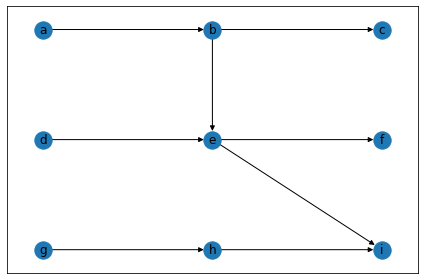

In [1]:
from datalife import get_critical_path, remove_cpath_from_graph, caterpillar_tree, find_caterpillar_forest

import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go


G = nx.DiGraph(
    [
        ("a", "b"),
        ('d', 'e'),        
        ('g','h'),
        ('b','e'),
        ('b','c'),
        ('e','f'),
        ('e','i'),
        ('h','i')
    ]
)

pos= { 'a': [0,0],
     'b': [1,0],
     'c': [2,0],
     'd':[0,-1],
      'e': [1,-1],
     'f':[2,-1],
     'g':[0,-2],
     'h':[1,-2],
     'i':[2,-2]}
fig, ax = plt.subplots()
nx.draw_networkx(G, pos=pos, ax=ax)
fig.tight_layout()
plt.show()

In [2]:
default_weight = 1
for n in G.edges():
    G.add_edge(n[0], n[1], weight=1)

G.add_weighted_edges_from([('d','e',2),('e','f',3)])

In [3]:
cpath = get_critical_path(G)
cpath

['d', 'e', 'f']

In [4]:
ct = caterpillar_tree(G, cpath)

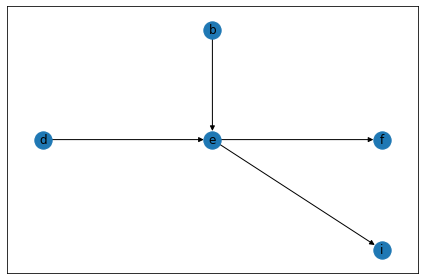

In [5]:
fig, ax = plt.subplots()
nx.draw_networkx(ct, pos=pos, ax=ax)
fig.tight_layout()
plt.show()

In [6]:
removed_g = remove_cpath_from_graph(G, cpath)

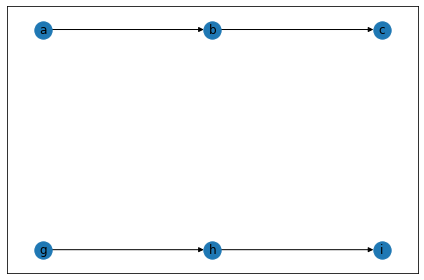

In [7]:
fig, ax = plt.subplots()
nx.draw_networkx(removed_g, pos=pos, ax=ax)
fig.tight_layout()
plt.show()

In [8]:
# find_caterpillar_forest in code
def find_caterpillar_forest(G):
    CT_s = []
    dependent_edges = []
    while(G.nodes or G.edges):
        # find a critical path
        cpath = get_critical_path(G)
        # extract the CT along the critical path
        CT_c = caterpillar_tree(G, cpath)
        # Remove the vertices and edges only along the critical path
        removed_g = remove_cpath_from_graph(G, cpath)
        # (find dependencies across CT_s) for each of the vertices,
        # v_c on the critical path of the current caterpillar tree, CT_c
        for node in CT_c.nodes:
            for ct_i in CT_s:
                # if there is an edge between v_p and v_c, 
                # add a dependency edge between CT_c  and ct_i
                o_edges = ct_i.out_edges(node)
                i_edges = ct_i.in_edges(node)
                dependent_edges += list(o_edges) + list(i_edges)
        dependent_edges = list(set(dependent_edges))
        CT_s.append(CT_c)
        G = removed_g
    return (CT_s, dependent_edges)

In [9]:
CT_s, dependent_edges = find_caterpillar_forest(G)
CT_s, dependent_edges

([<networkx.classes.digraph.DiGraph at 0x7fe6e591f650>,
 [('e', 'i'), ('b', 'e')])